# Particule swarm optimization

In [30]:
%reload_ext lab_black
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

from numpy import absolute
from numpy.random import uniform, choice
from random import randint


def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()


animation.Animation._repr_html_ = anim_to_html

In [56]:
# define a particle
class Particle:
    """
    Description
    ---------
    Class that represents one particle in the PSO.
    Attributes
    ---------
    position: numpy array
        Uniformly distributed random vector.
    velocity: float
        Particle's velocity.
    best_position: float
        Particle's best known position.
    neighbors_particles: list of Particle
        Neighbors of that Particle.
    """

    def __init__(self, position, velocity, best_position):
        self.position = position
        self.velocity = velocity
        self.best_position = best_position
        self.previous_best_position = [best_position]
        self.neighbors_particles = None

    def update_best_postion(self, best_position):
        self.best_position = best_position
        self.previous_best_position.append(best_position)

In [57]:
# function we want to find the optimum
def func(x, y):
    return (
        np.sin(x * 5 * np.pi) / ((x + 1) ** 2)
        + np.cos((y + x) * 6 * np.pi) / (2 + x + y)
        + 7 * ((x - 0.5) ** 2 + (y - 0.5) ** 2)
        + np.abs(x)
    )

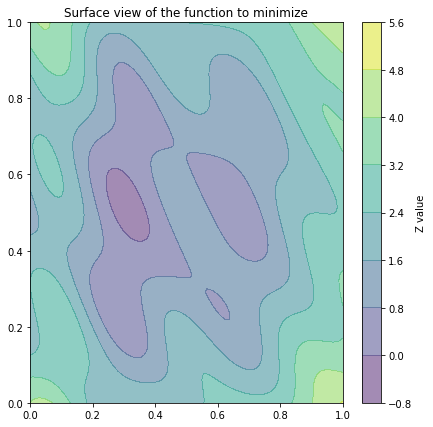

In [58]:
from mpl_toolkits.mplot3d import Axes3D

# plot the function to optimize
X, Y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
Z = np.zeros(X.shape)

for i in range(100):
    for j in range(100):
        Z[i, j] = func(X[i, j], Y[i, j])

fig = plt.figure(figsize=(7, 7))
c = plt.contourf(X, Y, Z, alpha=0.5)
plt.colorbar(c, label="Z value")
plt.title("Surface view of the function to minimize")
plt.show()

# plot in 3d
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection="3d")

ax.axis("off")
ax.view_init(-10, 30)

ax.plot_surface(X, Y, Z, cmap=plt.cm.viridis)


def animate(i):
    ax.view_init(-20, 30 + 4 * i)
    return []


animation.FuncAnimation(fig, animate, frames=90, interval=200, blit=True)

In [59]:
def generate_new_population(
    b_lo=0, b_up=1, n_dimensions=2, n_particles=100, swam_size=2
):
    # Generate particle population
    part_pop = []
    g = None  # Best known position (vector)

    for i in range(n_particles):
        part_velocity = uniform(
            -absolute(b_lo - b_up), absolute(b_lo - b_up), size=n_dimensions
        )
        part_position = uniform(low=b_lo, high=b_up, size=n_dimensions)
        best_position = part_position

        if g is not None:
            if func(best_position[0], best_position[1]) < func(g[0], g[1]):
                g = best_position.copy()
        else:
            g = best_position.copy()

        p = Particle(
            position=part_position, velocity=part_velocity, best_position=best_position
        )
        part_pop.append(p)

    print("Best known position (g) in the initial population:", g)
    print("Function value f(g): ", func(g[0], g[1]))

    # Define the swarm of each particle
    for particle in part_pop:
        neighbors = choice(part_pop, size=swam_size)
        particle.neighbors_particles = neighbors
    return part_pop, g

In [60]:
def plot_new_population(particle_pop):
    fig = plt.figure(figsize=(7, 7))
    plt.contour(X, Y, Z, alpha=0.5, levels=30)
    for part in particle_pop:
        plt.plot(
            part.position[0],
            part.position[1],
            "o",
            color="lightgray",
            alpha=0.8,
            markeredgecolor="k",
        )
    plt.plot(g[0], g[1], "o", color="#ff0000", label="Best known particle")
    plt.legend()
    plt.title("Initial population")
    plt.show()

In [61]:
# Algorithm parameters
(b_lo, b_up) = (0, 1)  # Lower and up boundaries
n_dimensions = 2  # Number of genes per particle
n_particles = 10  # Number of particles in population
swam_size = 2  # Number of neighbors for each particle (swarm)
n_iters = 5000  # Number of iterations (criterion)
omega = 0.5  # Omega contant
phi_p = 0.5  # Phi min particule constant
phi_g = 0.5  # Phi min global constant

Best known position (g) in the initial population: [0.25573665 0.35604432]
Function value f(g):  0.527106202004108


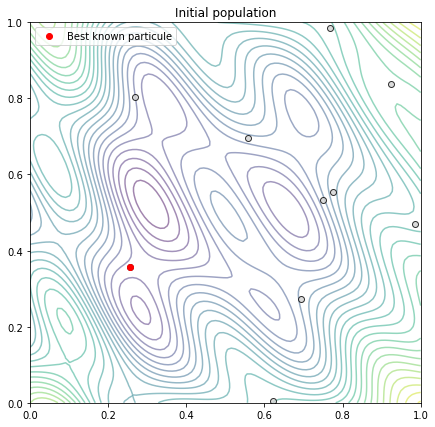

In [62]:
# generate a new population
particle_pop, g = generate_new_population(
    b_lo, b_up, n_dimensions, n_particles, swam_size
)
plot_new_population(particle_pop)

all_ = []
best_per_it = [g]

# configure plot for animation
fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
ax.contour(X, Y, Z, alpha=0.5, levels=20)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title(
    "Population of {} particles with swam of size {}.\n omega = {}, phi_p = {}, phi_g = {}".format(
        n_particles, swam_size, omega, phi_p, phi_g
    )
)


def init():
    return all_


def update(frame):
    global g, all_, patch
    [a.remove() for a in all_]
    all_.clear()

    for particle in particle_pop:
        # Get the current values
        tmp_vel = particle.velocity.copy()
        tmp_position = particle.position.copy()
        tmp_best_pos = particle.best_position.copy()

        # Update particle velociy
        new_velocity = []
        for d in range(n_dimensions):
            r_p, r_g = uniform(), uniform()
            v_id = (
                omega * tmp_vel[d]
                + phi_p * r_p * (tmp_best_pos[d] - tmp_position[d])
                + phi_g * r_g * (g[d] - tmp_position[d])
            )
            new_velocity.append(v_id)
        particle.velocity = np.array(new_velocity)

        # Update particle position
        tmp_position += new_velocity

        # If any dimension overcome the limits,
        # other values in the limits its generate for this dimension.
        tmp_position = [
            x if (-1 <= x <= 2) else uniform(low=b_lo, high=b_up) for x in tmp_position
        ]
        particle.position = np.array(tmp_position)

        # Update best positions
        if func(particle.best_position[0], particle.best_position[1]) > func(
            particle.position[0], particle.position[1]
        ):
            # Update the particles best known position
            particle.update_best_postion(particle.position)

            if func(particle.best_position[0], particle.best_position[1]) < func(
                g[0], g[1]
            ):
                # Update the swarms best known position
                g = particle.best_position
        # plot the best position for the particle
        all_ += ax.plot(
            particle.best_position[0],
            particle.best_position[1],
            "o",
            color="lime",
            alpha=0.5,
            markeredgecolor="g",
        )
        # plot the particule position
        all_ += ax.plot(
            particle.position[0],
            particle.position[1],
            "o",
            color="lightgray",
            alpha=0.8,
            markeredgecolor="k",
        )
    
    # append the new global best position
    best_per_it.append(g)

    # plot succesive best known positions
    all_ += ax.plot(
        np.array(best_per_it)[:, 0], np.array(best_per_it)[:, 1], "o-", color="#aa3a3a"
    )
    # plot best known position
    all_ += ax.plot(g[0], g[1], "o", color="#ff0000")

    return all_


animation.FuncAnimation(fig, update, init_func=init, frames=40, interval=500, blit=True)